# Ginelli L63 Code - Adaptive Integrator

Intended workflow is to save any quick runs here and plot over in plot file.

In [1]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt 
import scipy.integrate
from scipy.linalg import expm
from mpl_toolkits.mplot3d import Axes3D
import time as tm

## Utilities

In [2]:
# Vector field of the coupled Nonlinear dynamics and TLE

def TL63(t, state):
    """ ODEs defining coupled Lorenz 63 system and tangent dynamcis
    Parameter, state: current state.
    Parameter, t: time.
    Parameter, p: array, parameters for L63.
    """
    a = 10.0
    b = 8/3
    c = 28.0
    x, y, z, dx, dy, dz = state # x, y, z (nonlinear) dx, dy, dz (pertubation)
    
    # Nonlinear Lorenz Dynamics
    dxdt = a * (y - x)
    dydt = (c * x) - y - (x * z)
    dzdt = (x * y) - (b * z)

    # TLE
    ddxdt = a * (dy - dx)
    ddydt = (c - z) * dx - dy - (x * dz)
    ddzdt = (y * dx) + (x * dy) - (b * dz) 
    
    return [dxdt, dydt, dzdt, ddxdt, ddydt, ddzdt]

In [3]:
# Function for solving ODEs 

def solve(where, oldQ, t, tau):
    """ Simultaneuosly solve TLE and nonlinear dynamics. Returns stretched P = QR matrix.
    Parameter, where: where we are on attractor. [x, y, z]
    Parameter, oldQ: IC for tangent linear dynamics. Matrix, normally comes from Q, R decomposition.
    Parameter, t: time of where we are in the integration
    Parameter, tau: how long we solve TLE for.
    Returns [P_k, trajectory, time]
    """
    # Evolving first column of Q
    IC = [*where, *oldQ[:, 0]] # * unpacks list
    everything = scipy.integrate.solve_ivp(TL63, (t, t + tau), IC, dense_output = True) # Solving coupled system
    col1 = everything.y[3:, -1] # everythin.y is solution of coupled system. Last 3 index are TLE evolution
    
    # Evolving second column of Q
    IC = [*where, *oldQ[:, 1]] # * unpacks list
    everything = scipy.integrate.solve_ivp(TL63, (t, t + tau), IC, dense_output = True) # Solving coupled system
    col2 = everything.y[3:, -1] # everythin.y is solution of coupled system. Last 3 index are TLE evolution
    
    # Evolving third column of Q
    IC = [*where, *oldQ[:, 2]] # * unpacks list
    everything = scipy.integrate.solve_ivp(TL63, (t, t + tau), IC, dense_output = True, rtol = 1e-9) # Solving coupled system
    col3 = everything.y[3:, -1] # everythin.y is solution of coupled system. Last 3 index are TLE evolution
    
    # Getting current trajectory
    trajectory = everything.y[:3] # This is the trajectory we computed the above over. Note it's from last solution
    
    # Getting time trajectory was calculated over
    time = everything.t
    
    Pk = np.column_stack((col1, col2, col3))
    return [Pk, trajectory, time]
   

In [4]:
# Function to ensure QR decomposition has positive diagonals

def posQR(M):
    """ Returns QR decomposition of a matrix with positive diagonals on R.
    Parameter, M: Array that is being decomposed
    """
    Q, R = np.linalg.qr(M) # Performing QR decomposition
    signs = np.diag(np.sign(np.diagonal(R))) # Matrix with signs of R diagonal on the diagonal
    Q, R = np.dot(Q, signs), np.dot(signs, R) # Ensuring R Diagonal is positive
    return Q, R

## Setting Parameters

In [5]:
## Time
t0 = 0 # Starting time of integration
tau = 0.01 # How long in adimensional time before doing a QR decomposition
kA = int(1.e2) # BLV convergence steps
kB = int(2.e2) # Sampling steps
kC = kA # CLV convergence steps

## Initial conditions

# IC for TLE Matrix equation
eps = 0.1
oldQ = eps * np.identity(3)

where = np.array([0.1, 0.1 , 0.1]) # IC for L63
#IC = [*where, *oldQ[:, 0]] # Packing ICs together

## Storage

In [6]:
# Lyapunov Vectors are indexed via step, row, column
BLVs = np.zeros((int(kB), 3, 3)) 
Rs = np.zeros((int(kB), 3, 3))  # Stretching rates
Rs2 = np.zeros((int(kC), 3, 3))  # Stretching rates
CLVs = np.zeros((int(kB), 3, 3))

# Lyapunov exponents are indexed via step, then index of LE, beggining with largest LE
FTBLE = np.zeros((int(kB), 3)) # To store time series of FTBLES
BLE = np.zeros((kB, 3)) # Storing running mean of FTBLEs
FTCLE = np.zeros((int(kB), 3)) # To store time series of FTBLES
CLE = np.zeros((kB, 3)) # Storing running mean of FTBLEs

solution = [[where[0]], [where[1]], [where[2]]] # For storing trajectory
print(solution)

[[0.1], [0.1], [0.1]]


## Ginelli Algorithm

Problems occur if you don't rerun all steps 

### Step 1: BLV Convergence. 

In [7]:
start = tm.time()
for i in np.arange(kA): 
    # i will be storage index. Remember here storage(i) corresponds to time i * tau

    # Where we are
    step = i * tau
    #print([step, step + tau])
    
    # Solving L63 + TLE
    Pk, trajectory, time = solve(where, oldQ, step, tau) # Pk is matrix solution of TLE, trajectory is L63 solution
    where = trajectory[:, -1]
    
    # Storing L63 Trajectory
    solution[0].extend(trajectory[0, 1:]) # 1 is so we don't repeat points
    solution[1].extend(trajectory[1, 1:]) 
    solution[2].extend(trajectory[2, 1:]) 
    
    # QR Decomposition
    oldQ = Pk
    oldQ, R = posQR(Pk) 

### Step 2: More Benettin stepping. Here we sample BLVs and FTBLEs

In [8]:
tA = time[-1]
print(tA)
      
for i in np.arange(kB):
    # i will be storage index. Remember here storage(i) corresponds to time: (tA + i * tau) * dt
    
    # Where we are
    step = tA + (i * tau)
    where = trajectory[:, -1]
  
    # Solving L63 + TLE
    Pk, trajectory, time = solve(where, oldQ, step, tau) # Pk is matrix solution of TLE, trajectory is L63 solution
    where = trajectory[:, -1]
    
    # QR
    oldQ = Pk
    oldQ, R = posQR(Pk) # Performing Q, R decomposition with positive diagonal
    
    # Storage of FTBLEs
    ftble = np.log(np.diag(R))/(tau) # Note division by tau is done here
    FTBLE[i] = ftble
    BLE[i] = np.mean(FTBLE[0:i + 1], axis = 0)
    BLVs[i]= oldQ
    Rs[i] = R
    
    # Storing L63 Trajectory
    solution[0].extend(trajectory[0, 1:]) # 1 is so we don't repeat points
    solution[1].extend(trajectory[1, 1:]) 
    solution[2].extend(trajectory[2, 1:]) 

1.0


### Step 3: More Bennetin Stepping. Now we only store the Rs.

In [9]:
tB = time[-1]
print(tB)

for i in np.arange(kC): 
    
    # Where we are
    step = tB + (i * tau)
    where = trajectory[:, -1]
    
    # Solving L63 + TLE
    Pk, trajectory, time = solve(where, oldQ, step, tau) # Pk is matrix solution of TLE, trajectory is L63 solution
    where = trajectory[:, -1]
    
    #QR
    oldQ = Pk
    oldQ, R = posQR(Pk)

    # Storage
    Rs2[i] =  R
    
    # Storing L63 Trajectory
    solution[0].extend(trajectory[0, 1:]) # 1 is so we don't repeat points
    solution[1].extend(trajectory[1, 1:]) 
    solution[2].extend(trajectory[2, 1:]) 
#     print(f'Pk is\n{Pk}\n\n Q is\n {oldQ}\n\n R is\n {R}\n\n') 
#     print(f'Stored R is\n {Rs2[i]}\n\n') 

3.0


### Step 4: Time to go back, converging to A- matrix (Coefficient matrix of CLVs in BLV basis)

In [10]:
# Initialise an upper triangular matrix
A = np.identity(3)
A[0,1] = 1
oldA = A

In [11]:
tC = time[-1]
print(tC)

for i in np.arange(kC):
    
    # Where we are
    step = tC - (i * tau)
    #print([step, step - tau])
    
    # Pushing A- backwards with R's
    R = Rs2[kC - i - 1]
    newA = np.linalg.solve(R, oldA)
      
    # Normalises A's to prevent overflow
    norms = np.linalg.norm(newA, axis=0, ord=2) # L2 of column norms.
    oldA = newA/norms
    
    # Storing L63 Trajectory
    solution[0].extend(trajectory[0, 1:]) # 1 is so we don't repeat points
    solution[1].extend(trajectory[1, 1:]) 
    solution[2].extend(trajectory[2, 1:]) 

4.0


### Step 5: Keep going back, finding CLVs. Sample FTCLEs here.

In [12]:
for i in np.arange(kB):
    
    # Where we are
    step = tB - (i * tau) # Time is step * tau
    
    # Pushing A- backwards with R's
    R = Rs[kB - i - 1]
    newA = np.linalg.solve(R, oldA)
    
    # Sampling FTCLE 
    #ftcle = - np.log(np.diag(newA))/(tao * dt) # Norm for matching FTBLE
    norms = np.linalg.norm(newA, axis=0, ord=2) # L2 of column norms. Ensures CLVs are unit length
    ftcle = - np.log(norms)/(tau)# Notice minus sign for contraction
    
    # Storage
    FTCLE[kB - i - 1] = ftcle
    flipped = np.flip(FTCLE, axis = 0) #Flipped so we can calculate running mean
    CLE[kB - i - 1] = np.mean(flipped[0:i + 1], axis = 0) # Time series of estimated LE spectrum from FTCLEs
    
    # Storing L63 Trajectory
    solution[0].extend(trajectory[0, 1:]) # 1 is so we don't repeat points
    solution[1].extend(trajectory[1, 1:]) 
    solution[2].extend(trajectory[2, 1:]) 
    
    # Normalises A's to prevent overflow
    oldA = newA/norms 
    
    # Calculate CLV, using A- and BLV
    BLV = BLVs[kB - i - 1]
    CLVs[kB - i - 1] = np.matmul(BLV, oldA) 

end = tm.time()
print(f'It took {end - start} seconds.')

It took 2.6757092475891113 seconds.


## Quick Evaluation of Results

Plot of L63 Trajectory

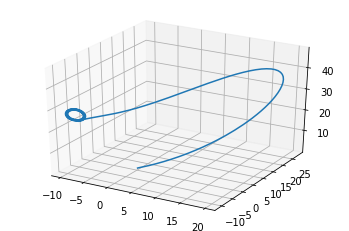

In [13]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(solution[0], solution[1], solution[2])
plt.show()

### Means (LE Spectrum)

In [14]:
litLEs = np.array([0.91, 0, -14.6])
print(f'The literature value of the FTCLEs is {litLEs}.\n')
print(f'The averaged value of the FTBLEs is {np.mean(FTBLE, axis = 0)}\n')
print(f'The averaged value of the FTCLEs is {np.mean(FTCLE, axis = 0)}.\n')

The literature value of the FTCLEs is [  0.91   0.   -14.6 ].

The averaged value of the FTBLEs is [  0.04128176   0.18708846 -13.89503674]

The averaged value of the FTCLEs is [  0.04128176   0.1021756  -13.89046782].



### Variance

In [15]:
print(f'For the FTBLE we have: \n\nVariance {np.var(FTBLE, axis = 0)}.\n\nSD is {np.std(FTBLE, axis = 0)}.\n')
print(f'For the FTCLE we have: \n\nVariance {np.var(FTCLE, axis = 0)}.\n\nSD is {np.std(FTCLE, axis = 0)}.\n')
print(f'Difference in varinace is {np.var(FTBLE, axis=0) - np.var(FTCLE, axis=0)}')

For the FTBLE we have: 

Variance [2.89253634 2.49638421 0.35592747].

SD is [1.70074582 1.579995   0.59659657].

For the FTCLE we have: 

Variance [2.89253634 2.72124683 0.29898564].

SD is [1.70074582 1.64962021 0.5467958 ].

Difference in varinace is [-4.44089210e-16 -2.24862623e-01  5.69418235e-02]


### Check sum

The sum of the CLEs is -13.74701046241085. It should be -13.666666666666666.

The sum of the BLEs is -13.666666521795412. It should be -13.666666666666666.


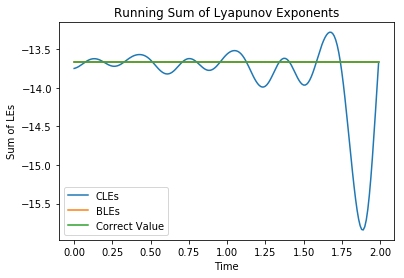

In [16]:
a = 10.0
b = 8/3
c = 28.0
print(f'The sum of the CLEs is {np.sum(CLE[0])}. It should be {-1 - a -b}.\n')
print(f'The sum of the BLEs is {np.sum(BLE[-1])}. It should be {-1 - a -b}.')

length = CLE.shape[0]
time = tau * (np.arange(length))
plt.plot(time, np.sum(CLE, axis=1), label='CLEs')
plt.plot(time, np.sum(BLE, axis=1), label='BLEs')
plt.plot(time, (-1 - a -b) * np.ones(CLE.shape[0]), label='Correct Value')
plt.xlabel('Time')
plt.ylabel('Sum of LEs')
plt.title('Running Sum of Lyapunov Exponents')
plt.legend()
plt.show()

# Saving Results

If you think data is worth looking at further. This is designed to be run from the cluster.

In [17]:
import os
import pickle

In [24]:
# Creating Directory to Save Results

dirName = f'tau{tau}-steps{kA + kB + kC:.1E}Cluster'
print(dirName)

if (os.path.exists(dirName)): # Checking if directory with same name exists
    print(f'There is already a directory called {dirName}. Not making another.')
else:
    os.mkdir(dirName)
    os.mkdir(dirName + '/Data') # For storing LVs and LEs

tau0.01-steps4.0E+02Cluster
There is already a directory called tau0.01-steps4.0E+02Cluster. Not making another.


In [25]:
# Pickling parameters

param_dict = {
    't0': t0,
    'tau': tau,
    'kA': kA,
    'kB': kB,
    'kC': kC,
    'eps': 0.01,
    'a': 10.0,
    'b': 8/3,
    'c': 28.0,
    'where': where
}

outfile = open(dirName + '/parameters','wb')
pickle.dump(param_dict,outfile)
outfile.close()

In [26]:
# Saving Data

path = dirName + '/Data/'
print('Data saved at ' + path)

np.save(f'{path}solution',solution) #Trajectory
np.save(f'{path}BLVs',BLVs)
np.save(f'{path}Rs',Rs)
np.save(f'{path}Rs2',Rs2)
np.save(f'{path}CLVs',CLVs)
np.save(f'{path}FTBLE',FTBLE)
np.save(f'{path}BLE',BLE)
np.save(f'{path}FTCLE',FTCLE)
np.save(f'{path}CLE',CLE)

Data saved at tau0.01-steps4.0E+02Cluster/Data/


In [153]:
EXPERIMENTAL STUFF

SyntaxError: invalid syntax (<ipython-input-153-fb89c3bdf476>, line 1)

### Plots of FTLEs Running Average

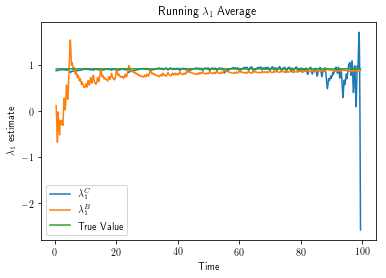

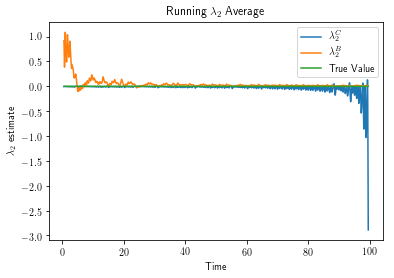

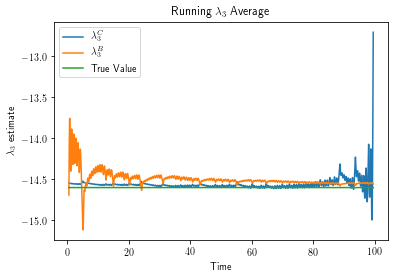

In [219]:
from matplotlib import rc
rc('text', usetex=True)

start = 50 # Starting index of plot
end = kB - 50 # End index plotted
time = tau * (np.arange(start, end))

# First LE
plt.plot(time, CLE[start:end, 0], label='$\lambda_1 ^C$')
plt.plot(time, BLE[start:end, 0], label='$\lambda_1 ^B$')
plt.plot(time, 0.91 * np.ones(end - start), label = 'True Value') # Literature value
#plt.plot(np.arange(length), means[0] * np.ones(length)) # Plotting mean value
plt.xlabel('Time')
plt.ylabel('$\lambda_1$ estimate')
plt.title('Running $\lambda_1$ Average')
plt.legend()
plt.savefig('First-LE.png')

# Second LE
plt.figure()
plt.plot(time, CLE[start:end, 1], label='$\lambda_2 ^C$')
plt.plot(time, BLE[start:end, 1], label='$\lambda_2 ^B$')
plt.plot(time, 0 * np.ones(end - start), label = 'True Value') # Literature value
#plt.plot(np.arange(length), means[0] * np.ones(length)) # Plotting mean value
plt.xlabel('Time')
plt.ylabel('$\lambda_2$ estimate')
plt.title('Running $\lambda_2$ Average')
plt.legend()
plt.savefig('Second-LE.png')

# Third LE
plt.figure()
plt.plot(time, CLE[start:end, 2], label='$\lambda_3 ^C$')
plt.plot(time, BLE[start:end, 2], label='$\lambda_3 ^B$')
plt.plot(time, -14.6 * np.ones(end - start), label = 'True Value') # Literature value
#plt.plot(np.arange(length), means[0] * np.ones(length)) # Plotting mean value
plt.xlabel('Time')
plt.ylabel('$\lambda_3$ estimate')
plt.title('Running $\lambda_3$ Average')
plt.legend()
plt.savefig('Third-LE.png')

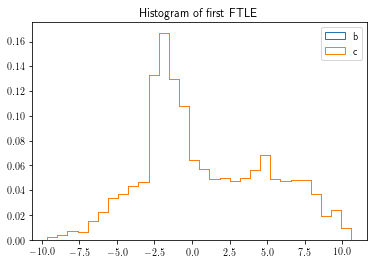

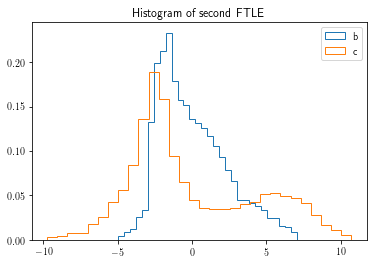

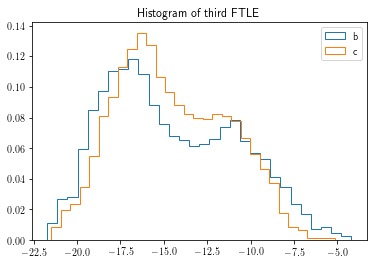

In [220]:
bins = 30
plt.hist(FTBLE[:,0], bins = bins, histtype = 'step', density = True , label = 'b')
plt.title("Histogram of First FTLE")
plt.savefig("FTBLE2-Histogram.png")

plt.hist(FTCLE[:,0], bins = bins,  histtype = 'step', density = True, label = 'c')
plt.title("Histogram of first FTLE")
plt.legend()
plt.savefig("FTCLE2-Histogram.png")



plt.figure()
plt.hist(FTBLE[:,1], bins = bins, histtype = 'step', density = True , label = 'b')
plt.title("Histogram of second FTLE")
plt.savefig("FTBLE2-Histogram.png")

plt.hist(FTCLE[:,1], bins = bins,  histtype = 'step', density = True, label = 'c')
plt.title("Histogram of second FTLE")
plt.legend()
plt.savefig("FTCLE2-Histogram.png")


plt.figure()
plt.hist(FTBLE[:,2], bins = bins, histtype = 'step', density = True, label = 'b')
plt.title("Histogram of third FTBLE")
plt.savefig("FTBLE3-Histogram.png")

# Covariant

# plt.figure()
# plt.hist(FTCLE[:,0], bins = bins)
# plt.title("Histogram of first FCTLE")
# plt.savefig("FTCLE1-Histogram.png")



plt.hist(FTCLE[:,2], bins = bins, histtype = 'step', density = True, label = 'c')
plt.legend()
plt.title("Histogram of third FTLE")
plt.savefig("FTCLE3-Histogram.png")

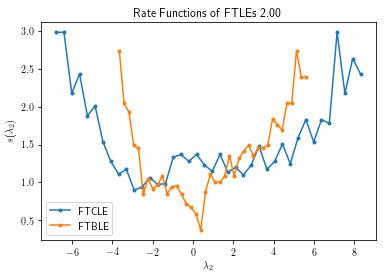

In [462]:
which = 2
bins = 40

index = which - 1

lelabel = ['$\\lambda_1$', '$\\lambda_2$', '$\\lambda_3$']

tao = 2.0
label = 'FTCLE' 
labelb = 'FTBLE' 
histb, edgesb = np.histogram(FTBLE[:, index], bins = bins, density = True) # Calculating histogram
hist, edges = np.histogram(FTCLE[:, index], bins = bins, density = True) # Calculating histogram
rate = - (np.log(hist) / tao) # Calculating rate function
rateb = - (np.log(histb) / tao) # Calculating rate function

plt.plot(edges[1:], rate, '.-', label = label) # THE X VALUE HERE IS A BIT FUDGED, MUST BE A BETTER WAY
plt.plot(edgesb[1:], rateb, '.-', label = labelb) # THE X VALUE HERE IS A BIT FUDGED, MUST BE A BETTER WAY FTBLE

plt.title(f'Rate Functions of FTLEs {tao:.2f}') # Plot features
plt.xlabel(f'{lelabel[index]}')
plt.ylabel('$s$(' + lelabel[index] + '$)$')
plt.legend()

[[1. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.0 1.0 0.0
[500, 50, 50]


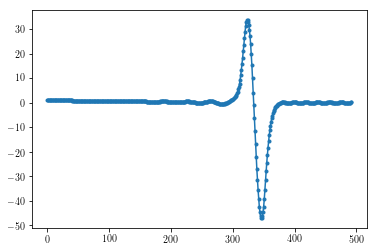

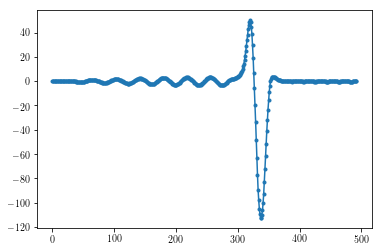

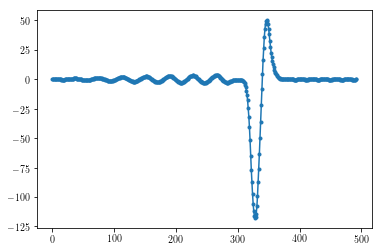

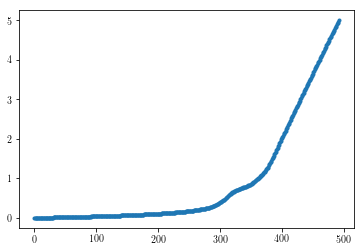

In [381]:
eps = 1
oldQ = eps * np.identity(3) # Initialise Orthogonal Matrix
oldQ[0, 2] = 1
print(oldQ)
print(*oldQ[:, 1])
where = [500, 50, 50]
print(where)
IC = [*where, *oldQ[:, 0]]
everything = scipy.integrate.solve_ivp(TL63, (0, 5), IC, dense_output = True, rtol = 1e-7 )
plt.plot(everything.y[3], '.-')
plt.figure()
plt.plot(everything.y[4], '.-')
plt.figure()
plt.plot(everything.y[5], '.-')


plt.figure()
plt.plot(everything.t, '.-')